# Сборный проект №2

### По данным с параметрами добычи и очистки подготовить прототип модели машинного обучения, которая должна предсказать коэффициент восстановления золота из золотосодержащей руды.

* gold_recovery_train.csv — обучающая выборка Скачать датасет;
* gold_recovery_test.csv — тестовая выборка Скачать датасет;
* gold_recovery_full.csv — исходные данные Скачать датасет.

Технологический процесс:
* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
* Xanthate — ксантогенат (промотер, или активатор флотации);
* Sulphate — сульфат (на данном производстве сульфид натрия);
* Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота
* Параметры этапов
* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи
* Наименование признаков
* Наименование признаков должно быть такое:

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

Возможные значения для блока [тип_параметра]:

* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

### Оглавление
1. Загрузка данных и библиотек
2. [Подготовка данных](#1)
3. [Анализ данных](#2)
4. [Создание и проверка моделей](#3)
5. [Общий вывод](#4)

# Загрузка данных и библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

In [2]:
full = pd.read_csv('/datasets/gold_recovery_full.csv')
test = pd.read_csv('/datasets/gold_recovery_test.csv')
train = pd.read_csv('/datasets/gold_recovery_train.csv')

In [3]:
for df in [full, test, train]:
    display(df.head())
    print(df.info())
    print()
    print('----------------------------------------------------------------')
    print()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
date                                          5856 non-null object
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.in

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

#### Вывод
Во всех датафреймах имеются множественные пропуски.

# Подготовка данных <a id=1></a>

Удалим пропуски и столбцы date. Попытка заполнить пропуски средним и 'ffill', увеличила MAE модели в разы. 

In [4]:
train.dropna(inplace=True)
test.dropna(inplace=True)
full.dropna(inplace=True)

Проверим правильность вычисление эффективности обогащения.

In [5]:
c = train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']

In [6]:
recovery = ((c*(f-t)) / (f*(c-t))) * 100

Ошибка очень маленькая, данные рассчитаны верно

In [7]:
mean_absolute_error(train['rougher.output.recovery'].loc[recovery.index], recovery)

9.555596961987514e-15

Проверим столбцы отсутсвующие в test

In [8]:
train.columns[~train.columns.isin(test.columns)]

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

В тестовой выборке отсутсутвуют концентрации вещества после этапов и эффективность обогащения. Эти данные замеряются и/или рассчитываются значительно позже. Мы не можем их использовать для обучения.

# Анализ данных <a id=2></a>

### Изменение концентрации металлов в процессе отчистки

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

In [9]:
concentrates = [['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag'],
                ['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au'],
                ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]
concentrates_tail = [['rougher.input.feed_ag', 'rougher.output.tail_ag', 'primary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_ag', 'final.output.tail_ag'],
                ['rougher.input.feed_au', 'rougher.output.tail_au', 'primary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_au', 'final.output.tail_au'],
                ['rougher.input.feed_pb', 'rougher.output.tail_pb', 'primary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_pb', 'final.output.tail_pb']]

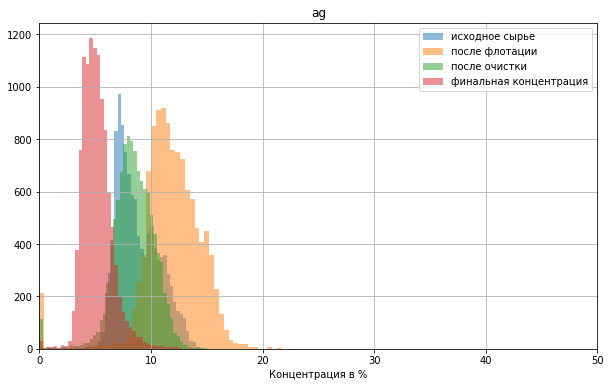

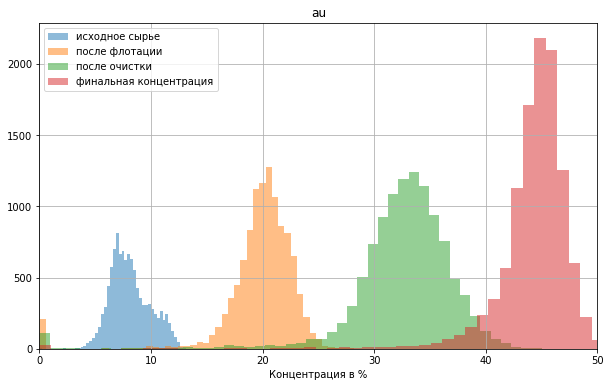

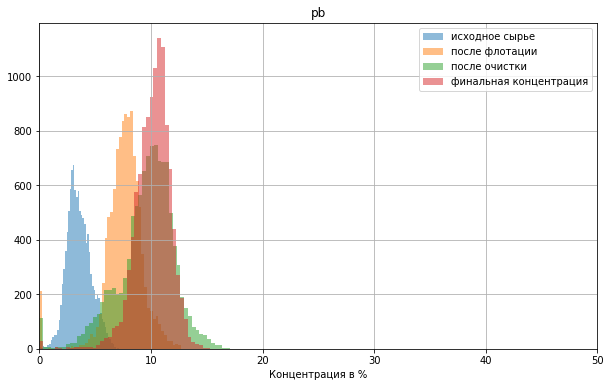

In [10]:
for step in concentrates:
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.hist(train[step[0]], bins=50, alpha=.5);
    plt.hist(train[step[1]], bins=50, alpha=.5);
    plt.hist(train[step[2]], bins=50, alpha=.5);
    plt.hist(train[step[3]], bins=50, alpha=.5);
    plt.xlim(0,50)
    plt.legend(['исходное сырье', 'после флотации', 'после очистки', 'финальная концентрация'])
    title = step[0].split('.')[2].split('_')[-1]
    plt.title(title)
    plt.xlabel('Концентрация в %')
    plt.show()

#### Вывод

Для золота виден значительный рост концентрации в процессе обработки. Содержание серебра уменьшается. Так же значительно увеличивается концентрация свинца.

### Концентрация металлов в отвальных хвостах

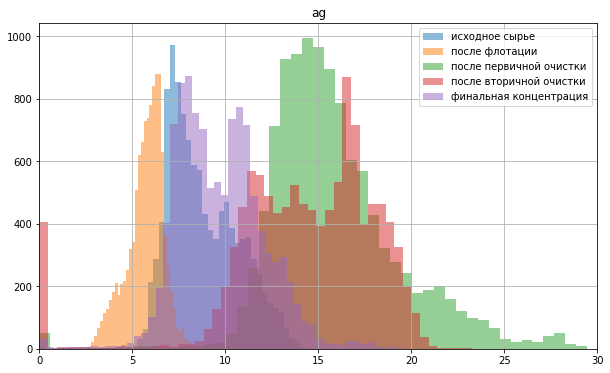

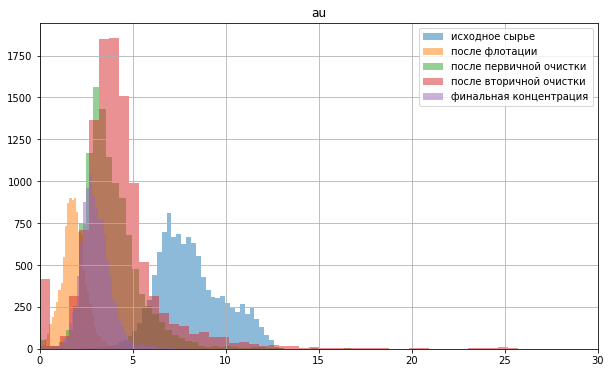

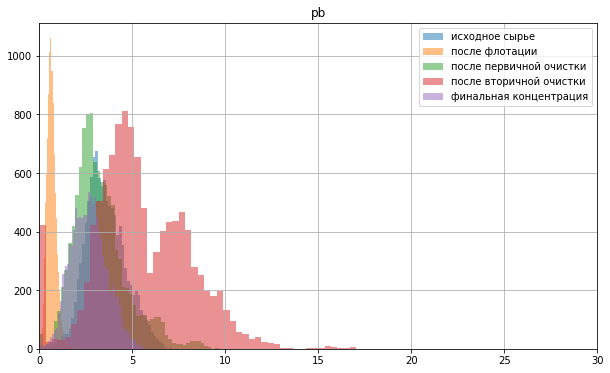

In [11]:
for step in concentrates_tail:
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.hist(train[step[0]], bins=50, alpha=.5);
    plt.hist(train[step[1]], bins=50, alpha=.5);
    plt.hist(train[step[2]], bins=50, alpha=.5);
    plt.hist(train[step[3]], bins=50, alpha=.5);
    plt.hist(train[step[4]], bins=50, alpha=.5);
    plt.legend(step)
    plt.xlim(0,30)
    title = step[0].split('.')[2].split('_')[-1]
    plt.title(title)
    plt.legend(['исходное сырье', 'после флотации', 'после первичной очистки', 'после вторичной очистки', 'финальная концентрация'])
    plt.show()

#### Вывод

Большая часть серебра уходит в хвосты в процессе первичной и вторичной очистки. Флотация плохо отделяет металлы.

### Размер гранул

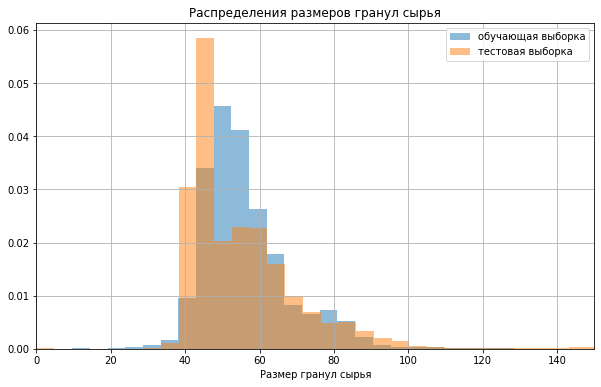

In [12]:
plt.figure(figsize=(10,6))
plt.grid()
plt.hist(train['rougher.input.feed_size'], bins=100, alpha=.5, density=True);
plt.hist(test['rougher.input.feed_size'], bins=100, alpha=.5, density=True);
plt.xlim(0, 150)
plt.legend(['обучающая выборка', 'тестовая выборка'])
plt.title('Распределения размеров гранул сырья')
plt.xlabel('Размер гранул сырья')
plt.show()

In [13]:
train['rougher.input.feed_size'].describe()

count    11017.000000
mean        57.215128
std         18.913146
min          9.659576
25%         48.397242
50%         53.843359
75%         61.461770
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [14]:
test['rougher.input.feed_size'].describe()

count    5383.000000
mean       56.338644
std        21.836788
min         0.046369
25%        43.913766
50%        50.924232
75%        62.364984
max       477.445473
Name: rougher.input.feed_size, dtype: float64

#### Вывод
Размер гранул сырья отличается незначительно.

### Концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [15]:
input_s = ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol']
output_s = ['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol']
final_s = ['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol']

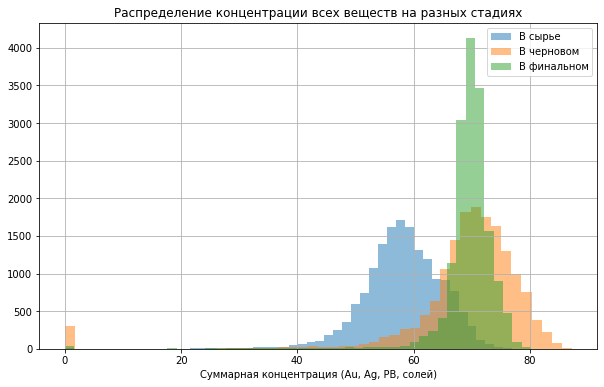

In [16]:
plt.figure(figsize=(10,6))
plt.grid()
plt.hist(full[input_s].sum(axis=1), bins=50, alpha=.5);
plt.hist(full[output_s].sum(axis=1), bins=50, alpha=.5);
plt.hist(full[final_s].sum(axis=1), bins=50, alpha=.5);
plt.legend(['В сырье', 'В черновом', 'В финальном'])
plt.title('Распределение концентрации всех веществ на разных стадиях')
plt.xlabel('Суммарная концентрация (Au, Ag, PB, солей)')
plt.show()

#### Вывод <a id=13></a>

Анамальными можно назвать 0 значения. Удалим эти строки.

In [17]:
train = train[(train['final.output.concentrate_ag'] != 0) & (train['rougher.output.concentrate_au'] != 0)]

# Создание и проверка моделей <a id=3></a>

### Разбивка на воборки

Для обучения будем использовать столбцы из тестовой выборки

In [18]:
X_train = train[test.columns].drop('date', axis=1)

In [19]:
y_train = train[['rougher.output.recovery', 'final.output.recovery']]

Присоединим столбцы с истинными значениями целевых показателей из full

In [20]:
test = test.merge(full[['date', 'rougher.output.recovery', 'final.output.recovery']], how='left', on='date').dropna()
X_test = test.drop(['date', 'rougher.output.recovery', 'final.output.recovery'], axis=1)
y_test = test[['rougher.output.recovery', 'final.output.recovery']]

Проведем масштабирование признаков

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Scorer <a id=11> </a>

In [22]:
def smape(true, pred):
    total = ((abs(true - pred) / ((abs(true) + abs(pred))/2)).sum())*100 / len(true)
    return total[0]*0.25 + total[1]*0.75

In [23]:
smape_score = make_scorer(smape, greater_is_better=False)

### LinearRegression

In [24]:
model = LinearRegression()
print('Значение кроссвалидации ', pd.Series((cross_val_score(model, X_train, y_train, cv=3, scoring=smape_score))).mean())

Значение кроссвалидации  -9.993079950898967


### Параметры для DecisionTreeRegressor и RandomForestRegressor <a id=12></a>

In [25]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
dt_grid = {    'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rf_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


### DecisionTreeRegressor

In [26]:
dt = DecisionTreeRegressor()
dt_random = RandomizedSearchCV(scoring=smape_score, 
                               estimator = dt, 
                               param_distributions = dt_grid, 
                               n_iter = 50, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1)
dt_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, total=   0.6s
[CV] min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, total=   0.5s
[CV] min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None 
[CV]  min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, total=   0.6s
[CV] min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None 
[CV]  min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, total=   0.1s
[CV] min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None 
[CV]  min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, total=   0.1s
[CV] min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None 
[CV]  min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=None, total=   0.1s
[CV] min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=80 
[CV]  min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=80, total=   0.1s
[CV] min_samples_split=

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   45.2s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DecisionTreeRegressor(criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort=False,
                                                   random_state=None,
                                                   splitter='best'),
                   iid='warn', n_iter=50, n_jobs=-1,
                   param_dist

In [27]:
dt_random.best_score_

-10.49071942133451

### RandomForestRegressor

In [28]:
'''
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(scoring=smape_score, estimator = rf, param_distributions = rf_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_score_
'''

'\nrf = RandomForestRegressor()\nrf_random = RandomizedSearchCV(scoring=smape_score, estimator = rf, param_distributions = rf_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)\nrf_random.fit(X_train, y_train)\nrf_random.best_score_\n'

В онлайн jupiter обучение проходило очень долго, добавил параметры с локальной модели

In [29]:
model = RandomForestRegressor(n_estimators=150, 
                              min_samples_split=5, 
                              min_samples_leaf=4, 
                              max_features='sqrt',
                              max_depth=70,
                              bootstrap = True, 
                              random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [30]:
print('Значение кроссвалидации ', pd.Series((cross_val_score(model, X_train, y_train, cv=3, scoring=smape_score))).mean())

Значение кроссвалидации  -8.585895571837387


#### Вывод
Лучший показатель у RandomForestRegressor

# Общий вывод <a id=4>

In [31]:
smape(y_test, model.predict(X_test))

8.252895093717049

Итоговое значение smape у лучшей модели составил 8.25.